## 1. Load some useful library for analysis

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from arch import arch_model
from scipy.stats import norm
import scipy.stats
import pylab
import plotly.graph_objects as go
import seaborn as sns
import pymannkendall as mk
import plotly.express as px
sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error

2023-05-10 06:59:59.934790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load the data

In [2]:
raw_data = pd.read_csv('/Users/mcardonasanchez/Desktop/Online Courses/The-Data-Science-Course-2021-All-Resources/Assessment-Centre-Strategy-Activity/data.csv')
df = raw_data.copy()
print(df.shape)
print(df.columns)
df.head(10)

(5000, 10)
Index(['Date', 'Asset', 'Signal1', 'Signal2', 'Signal3', 'Signal4', 'Signal5',
       'Signal6', 'Signal7', 'Signal8'],
      dtype='object')


,Date,Asset,Signal1,Signal2,Signal3,Signal4,Signal5,Signal6,Signal7,Signal8
0,2000-01-03,4258.481700,4237.827494,393.780879,-337.933192,659.763906,-752.865453,1034.127659,-950.257818,198.264577
1,2000-01-04,4260.246443,4222.822224,378.585650,-364.449284,648.940384,-732.505856,1042.256957,-977.358249,211.206055
2,2000-01-05,4262.254628,4213.824762,389.955615,-391.594831,641.329710,-728.611976,1063.217724,-951.518386,198.595598
3,2000-01-06,4289.405332,4239.016108,406.660516,-333.249594,683.822313,-729.657222,1079.316062,-932.785850,181.822031
4,2000-01-07,4293.746629,4232.818801,403.366787,-320.479903,682.553985,-713.180569,1087.226725,-941.674136,197.875560
5,2000-01-10,4311.970686,4228.845149,413.749839,-288.097316,681.237390,-722.553177,1097.412119,-943.391467,212.152788
6,2000-01-11,4326.173719,4199.608920,394.909468,-293.436046,685.068351,-707.972621,1081.896516,-946.380044,205.272782
7,2000-01-12,4358.074625,4215.387698,398.256016,-288.451123,699.542201,-698.375011,1072.855393,-986.138310,211.834670
8,2000-01-13,4356.275711,4245.368791,427.906417,-264.539216,696.706451,-691.152081,1083.184939,-968.847091,228.131274
9,2000-01-14,4336.095967,4253.875513,433.229688,-280.090382,699.424044,-701.750340,1099.384857,-958.402051,214.266060


In [3]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df.set_index('Date', inplace=True)
df = df.asfreq('b', 'ffill')

## 3. Some example plotting

<AxesSubplot: xlabel='Date'>

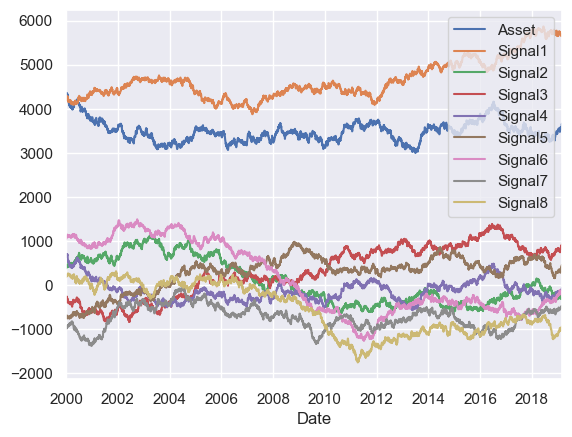

In [4]:
df.plot()

In [5]:
df.describe()

,Asset,Signal1,Signal2,Signal3,Signal4,Signal5,Signal6,Signal7,Signal8
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3480.620481,4648.060993,79.753967,314.459974,-134.766618,281.706691,132.436927,-732.772162,-551.930412
std,234.246112,454.406972,509.367342,587.404261,231.225251,379.551188,800.617031,265.703220,564.471453
min,2993.056357,3874.012411,-659.930614,-837.937510,-568.346058,-761.691924,-1269.500666,-1384.673211,-1758.683325
25%,3310.280673,4336.661660,-377.552886,-242.193429,-307.397373,224.937938,-541.018494,-929.068078,-1060.552805
50%,3461.383064,4539.173279,-95.508702,272.760895,-162.889629,365.737881,-271.856019,-709.056389,-615.555115
75%,3603.662660,4916.916416,586.143387,808.984482,-12.059275,515.650774,971.733196,-551.447496,18.726762
max,4358.074625,5865.391213,1112.601061,1384.083157,699.542201,978.979367,1489.311283,-63.593013,306.729373


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2000-01-03 to 2019-03-01
Freq: B
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Asset    5000 non-null   float64
 1   Signal1  5000 non-null   float64
 2   Signal2  5000 non-null   float64
 3   Signal3  5000 non-null   float64
 4   Signal4  5000 non-null   float64
 5   Signal5  5000 non-null   float64
 6   Signal6  5000 non-null   float64
 7   Signal7  5000 non-null   float64
 8   Signal8  5000 non-null   float64
dtypes: float64(9)
memory usage: 390.6 KB


## 4. Profit!

## Study of the asset

Text(0.5, 1.0, 'Correlation of asset and signals')

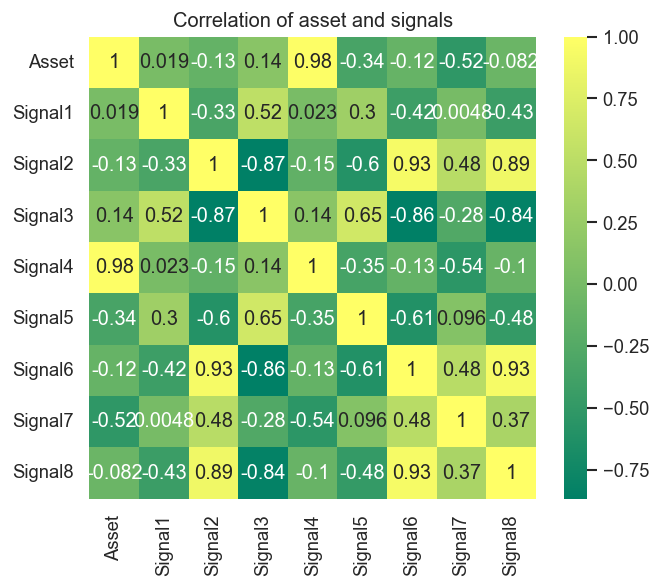

In [64]:
plt.figure(figsize=(6, 5))

# plt.subplot(2, 2, 1)
sns.heatmap(df.corr(), annot=True, cmap='summer')
plt.title('Correlation of asset and signals')

In [7]:
fig = px.box(df, y="Asset")
fig.show()

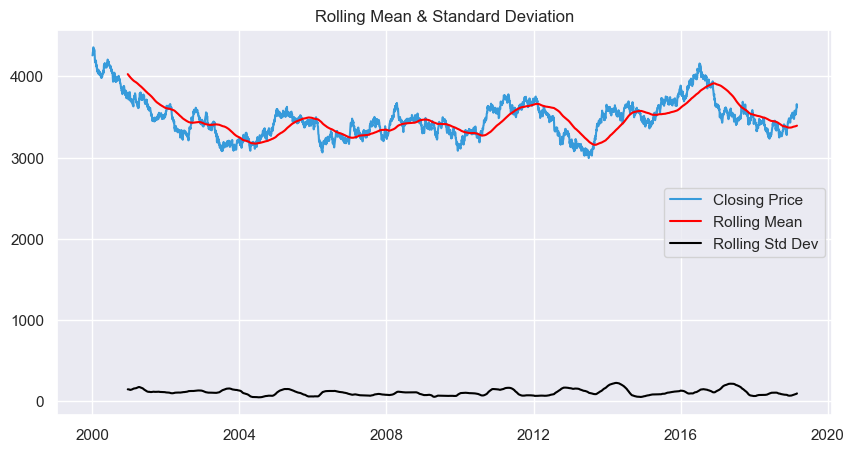

In [8]:
# Rolling Statistics

#  Yearly
# Quarterly
rolling_avg = df.Asset.rolling(window=252).mean()
rolling_std = df.Asset.rolling(window=252).std()

# Plot rolling statistics
plt.figure(figsize=(10,5))
plt.plot(df.Asset, color='#379BDB', label='Closing Price')
plt.plot(rolling_avg,color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std Dev')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


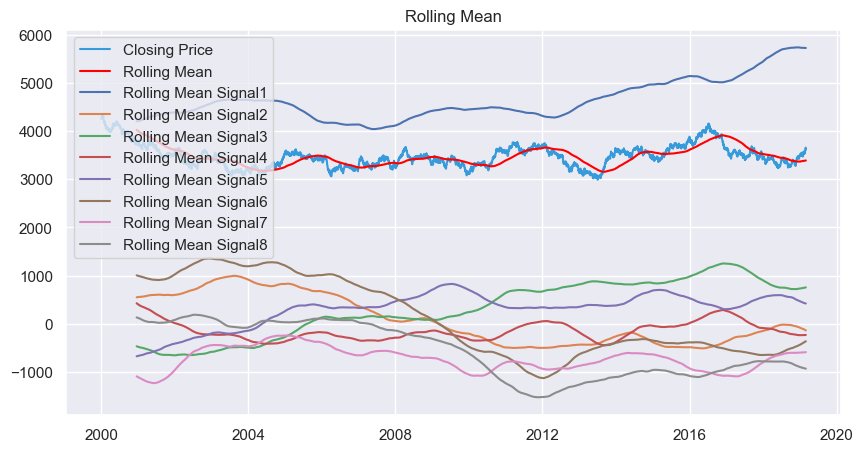

In [9]:
signals = ['Signal1', 'Signal2', 'Signal3', 'Signal4', 'Signal5', 'Signal6','Signal7','Signal8']

ma_df = df.copy()
for signal in signals:
    ma_df[signal] = df[signal].rolling(252).mean()
        

# Plot rolling statistics
plt.figure(figsize=(10,5))
plt.plot(df.Asset, color='#379BDB', label='Closing Price')
plt.plot(rolling_avg,color='red', label='Rolling Mean')

plt.plot(ma_df.Signal1, label='Rolling Mean Signal1')
plt.plot(ma_df.Signal2, label='Rolling Mean Signal2')
plt.plot(ma_df.Signal3, label='Rolling Mean Signal3')
plt.plot(ma_df.Signal4, label='Rolling Mean Signal4')
plt.plot(ma_df.Signal5, label='Rolling Mean Signal5')
plt.plot(ma_df.Signal6, label='Rolling Mean Signal6')
plt.plot(ma_df.Signal7, label='Rolling Mean Signal7')
plt.plot(ma_df.Signal8, label='Rolling Mean Signal8')

plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show(block=False)


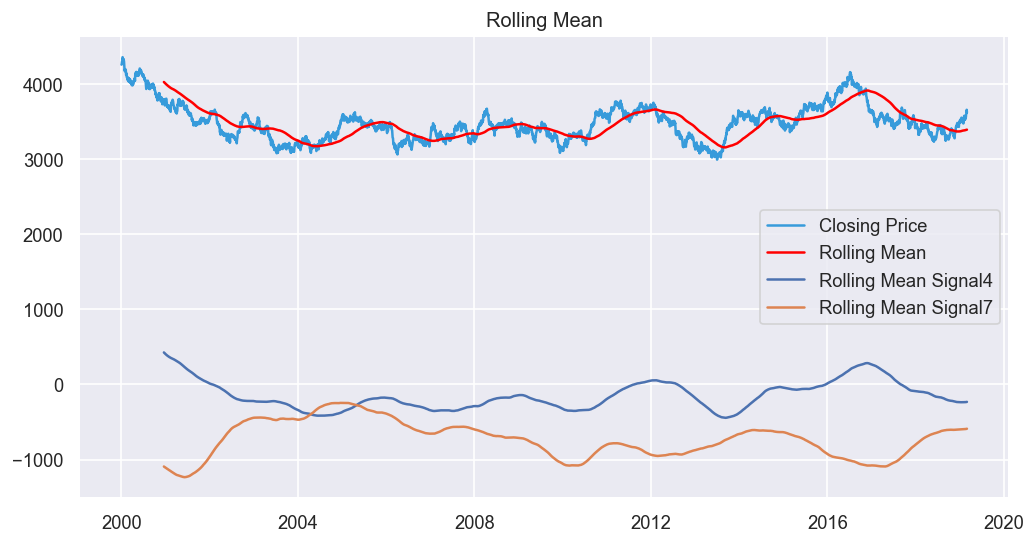

In [65]:
# Plot rolling statistics
plt.figure(figsize=(10,5))
plt.plot(df.Asset, color='#379BDB', label='Closing Price')
plt.plot(rolling_avg,color='red', label='Rolling Mean')

plt.plot(ma_df.Signal4, label='Rolling Mean Signal4')
plt.plot(ma_df.Signal7, label='Rolling Mean Signal7')

plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show(block=False)


One Month Lag:  0.9967458820647355
Three Month Lag:  0.9901928519504799
Six Month Lag:  0.9807505212418005
Nine Month Lag:  0.9709986599810428
Twelve Month Lag:  0.9619834609116669


<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

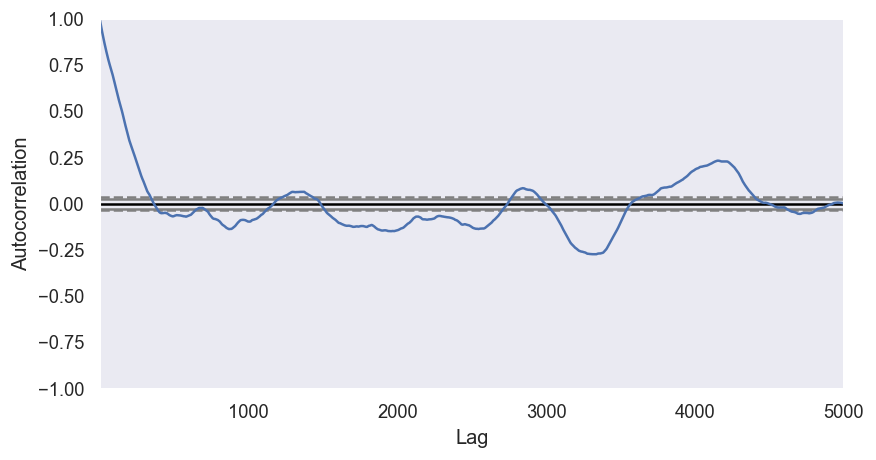

In [10]:
# Study Autocorrelation
from pandas.plotting import autocorrelation_plot

autocorrelation_lag1 = df['Asset'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df['Asset'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['Asset'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['Asset'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

autocorrelation_lag12 = df['Asset'].autocorr(lag=12)
print("Twelve Month Lag: ", autocorrelation_lag12)

# Draw Plot
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
autocorrelation_plot(df['Asset'].tolist())

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

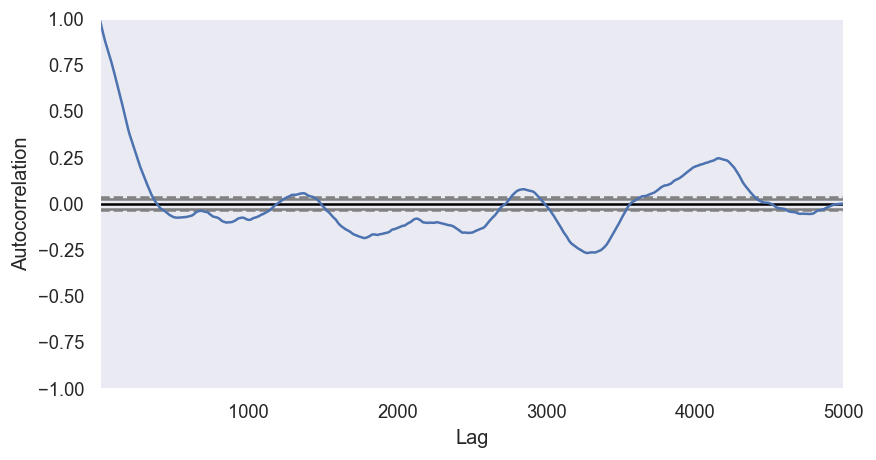

In [69]:
# Draw Plot
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
autocorrelation_plot(df['Signal4'].tolist())

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

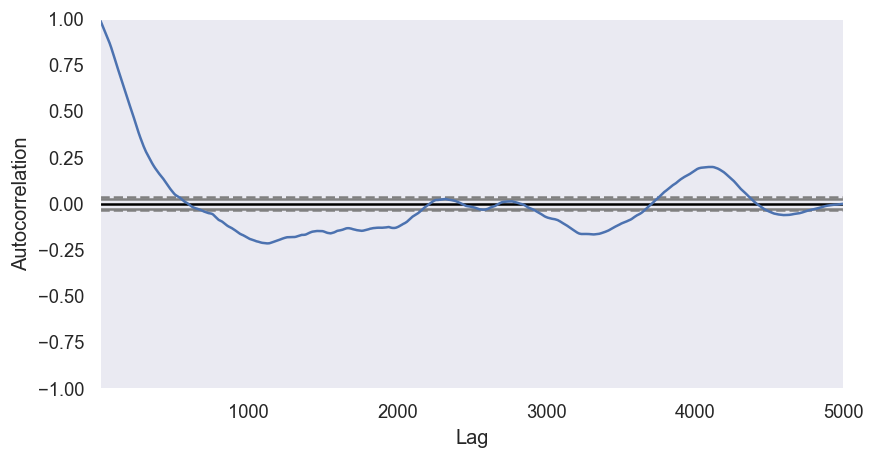

In [70]:
# Draw Plot
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
autocorrelation_plot(df['Signal7'].tolist())

In [11]:
df.corr()

,Asset,Signal1,Signal2,Signal3,Signal4,Signal5,Signal6,Signal7,Signal8
Asset,1.000000,0.019285,-0.133649,0.136293,0.980973,-0.335833,-0.116256,-0.523441,-0.081898
Signal1,0.019285,1.000000,-0.325971,0.523115,0.022580,0.299043,-0.420728,0.004774,-0.433259
Signal2,-0.133649,-0.325971,1.000000,-0.867054,-0.153361,-0.603814,0.933157,0.480915,0.890107
Signal3,0.136293,0.523115,-0.867054,1.000000,0.142013,0.654428,-0.860524,-0.275160,-0.837760
Signal4,0.980973,0.022580,-0.153361,0.142013,1.000000,-0.351524,-0.133902,-0.543719,-0.104709
Signal5,-0.335833,0.299043,-0.603814,0.654428,-0.351524,1.000000,-0.612357,0.096259,-0.481553
Signal6,-0.116256,-0.420728,0.933157,-0.860524,-0.133902,-0.612357,1.000000,0.481808,0.932667
Signal7,-0.523441,0.004774,0.480915,-0.275160,-0.543719,0.096259,0.481808,1.000000,0.374479
Signal8,-0.081898,-0.433259,0.890107,-0.837760,-0.104709,-0.481553,0.932667,0.374479,1.000000


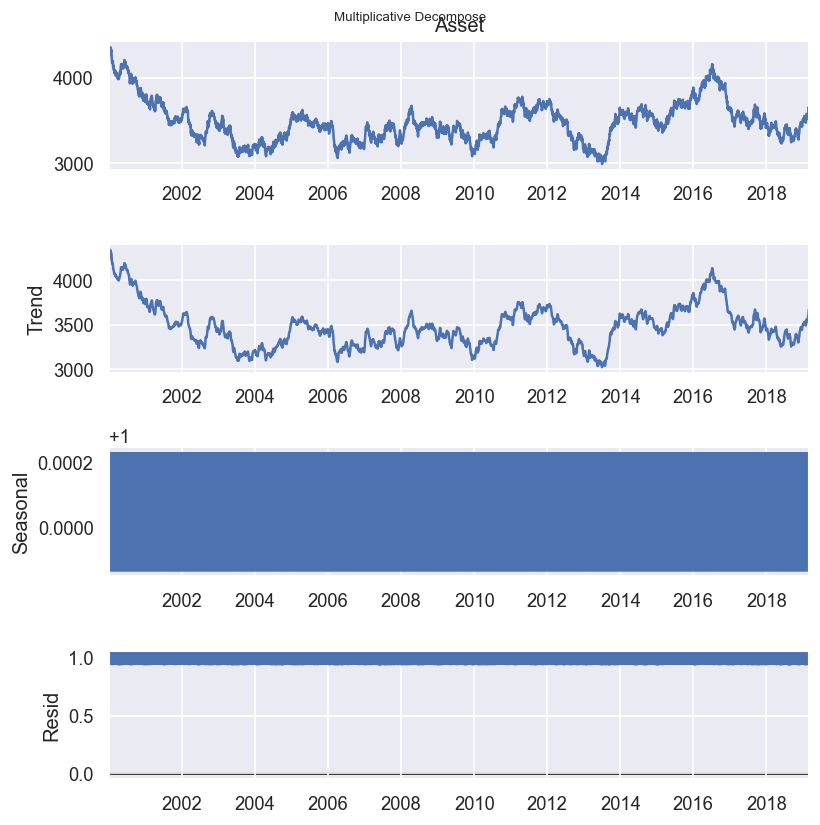

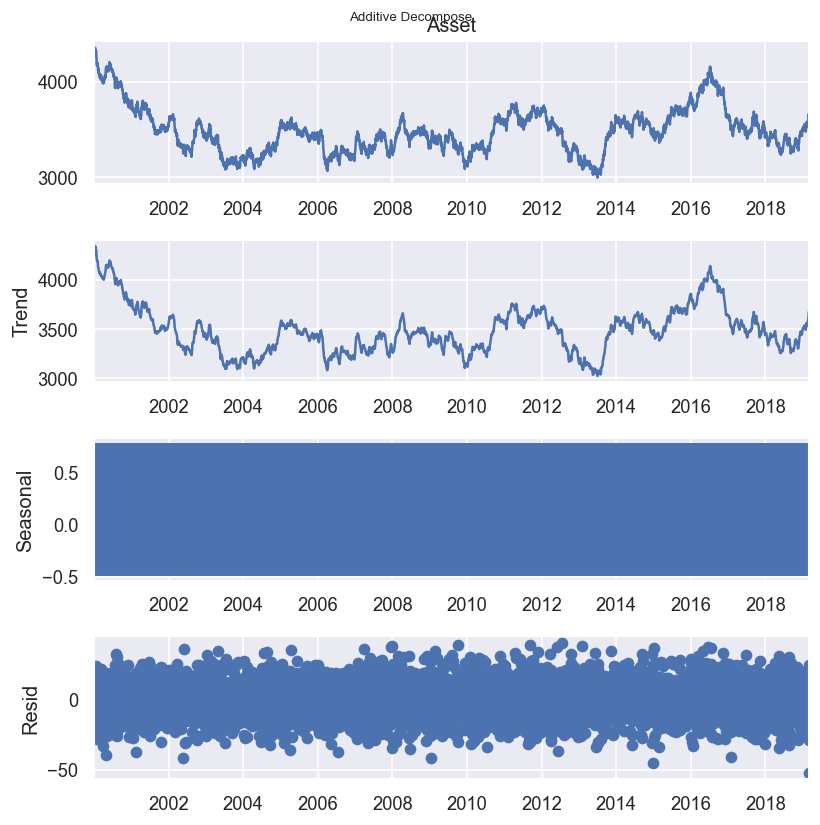

In [12]:
# Seasonality of Asset

# Multiplicative Decomposition
result_mult = seasonal_decompose(df.Asset, model='multiplicative', extrapolate_trend='freq')

# Aditive Decomposition
result_add = seasonal_decompose(df.Asset, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (7,7)})
result_mult.plot().suptitle('Multiplicative Decompose', fontsize=8)
result_add.plot().suptitle('Additive Decompose', fontsize=8)
plt.show()

In [13]:
# Augmented Dickey-Fuller test
print('Results of Dickey Fuller Test:')
df_ad_test = adfuller(df.Asset, autolag='AIC')

dfoutput = pd.Series(df_ad_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in df_ad_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)
if dfoutput[1]<0.05:
    print('p-value is %s, meaning that there is enough evidence to say the data is stationary'%dfoutput[1])
else:
    print('p-value is %s, meaning that there is NOT enough evidence to say the data is stationary'%dfoutput[1])

Results of Dickey Fuller Test:
Test Statistic                   -3.783320
p-value                           0.003083
#Lags Used                        2.000000
Number of Observations Used    4997.000000
Critical Value (1%)              -3.431659
Critical Value (5%)              -2.862119
Critical Value (10%)             -2.567078
dtype: float64
p-value is 0.003082662771802467, meaning that there is enough evidence to say the data is stationary


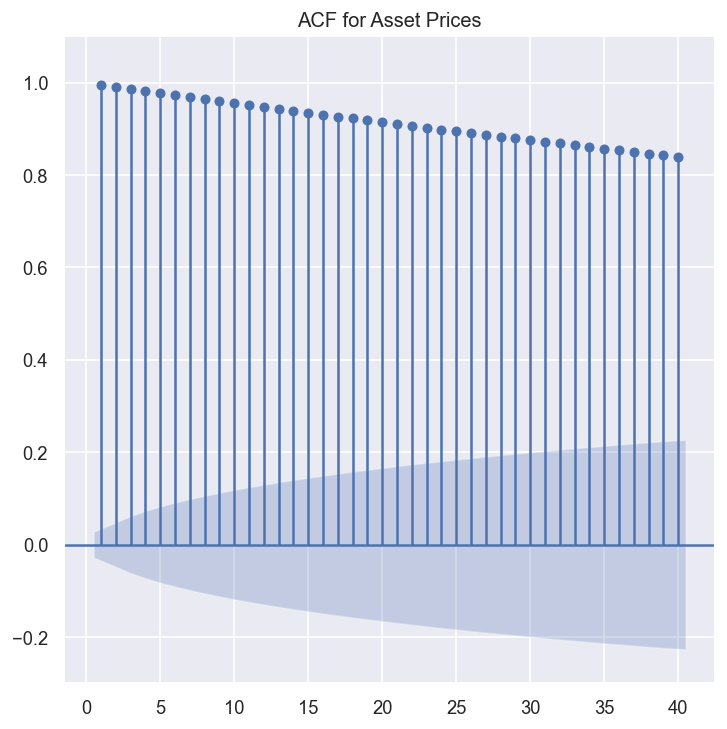

In [67]:
# ACF
sgt.plot_acf(df.Asset, zero=False, lags=40)
plt.title('ACF for Asset Prices')
plt.ylim([-0.3, 1.1])
plt.show()

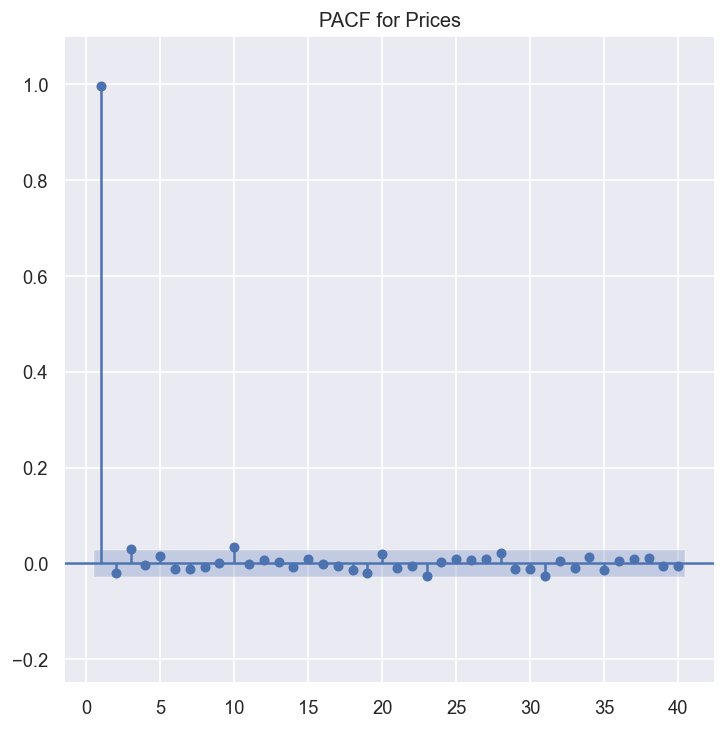

In [15]:
sgt.plot_pacf(df.Asset, lags=40, alpha = 0.05, zero=False, method=('ols'))
plt.title('PACF for Prices')
plt.ylim([-0.25,1.1])
plt.show()

### Returns

In [24]:
# Daily percentage change

returns_df = pd.DataFrame()
returns_df['Asset'] = 100*df.Asset.pct_change()

for signal in signals:
    returns_df[signal] = 100*df[signal].pct_change()

returns_df = returns_df.iloc[1:]
returns_df.head()

,Asset,Signal1,Signal2,Signal3,Signal4,Signal5,Signal6,Signal7,Signal8
Date,,,,,,,,,
2000-01-04,0.041441,-0.354079,-3.858803,7.846549,-1.640514,-2.704281,0.786102,2.851903,6.527378
2000-01-05,0.047138,-0.213067,3.003274,7.448374,-1.172785,-0.531583,2.011094,-2.643848,-5.970689
2000-01-06,0.637003,0.597826,4.283796,-14.899389,6.625703,0.143457,1.514115,-1.968699,-8.446092
2000-01-07,0.101210,-0.146197,-0.809946,-3.831870,-0.185476,-2.258136,0.732933,0.952875,8.829254
2000-01-10,0.424433,-0.093877,2.574097,-10.104405,-0.192892,1.314198,0.936823,0.182370,7.215256


Text(0.5, 1.0, 'Correlation of returns')

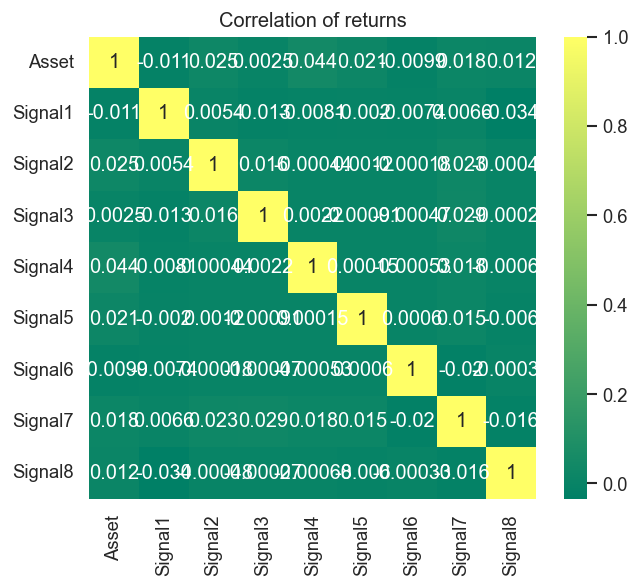

In [68]:

plt.figure(figsize=(6, 5))
# plt.subplot(2, 2, 2)
sns.heatmap(returns_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of returns')

In [26]:
returns_df.corr()

,Asset,Signal1,Signal2,Signal3,Signal4,Signal5,Signal6,Signal7,Signal8
Asset,1.000000,-0.010942,0.024784,0.002545,0.043864,0.021157,-0.009898,0.017668,0.011873
Signal1,-0.010942,1.000000,0.005423,-0.013057,-0.008055,-0.002027,-0.007413,0.006565,-0.033738
Signal2,0.024784,0.005423,1.000000,0.015683,-0.000436,0.001219,-0.000179,0.023221,-0.000479
Signal3,0.002545,-0.013057,0.015683,1.000000,0.002189,-0.000906,-0.000474,0.028542,-0.000274
Signal4,0.043864,-0.008055,-0.000436,0.002189,1.000000,0.000154,-0.000534,0.018118,-0.000676
Signal5,0.021157,-0.002027,0.001219,-0.000906,0.000154,1.000000,0.000595,0.015021,-0.006037
Signal6,-0.009898,-0.007413,-0.000179,-0.000474,-0.000534,0.000595,1.000000,-0.019786,-0.000331
Signal7,0.017668,0.006565,0.023221,0.028542,0.018118,0.015021,-0.019786,1.000000,-0.015889
Signal8,0.011873,-0.033738,-0.000479,-0.000274,-0.000676,-0.006037,-0.000331,-0.015889,1.000000


Mean Return: -0.0017475551157743927, Volatility: 0.2979779371286647


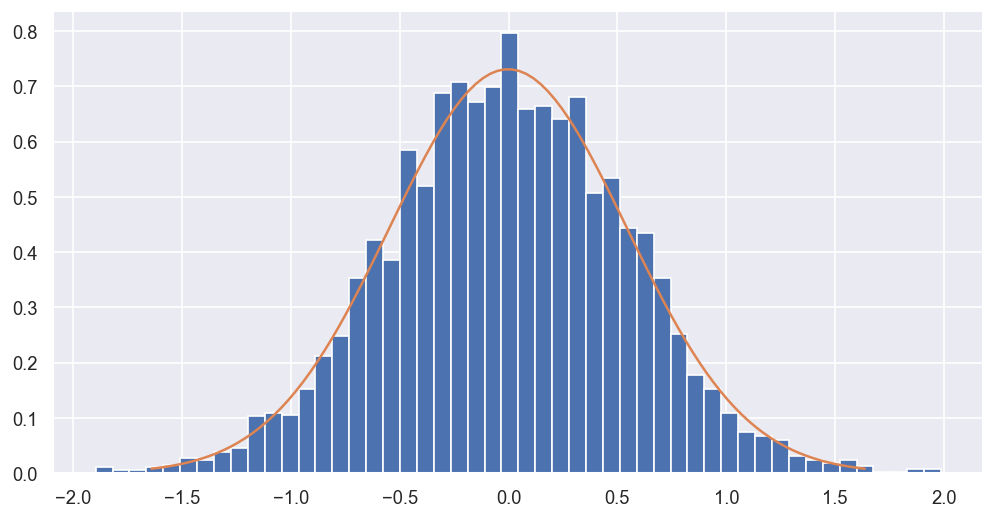

In [27]:
# Visualise Asset Returns
fig = px.box(returns_df, y='Asset')
fig.show()

fig, ax = plt.subplots(figsize=(10,5))
plt.hist(returns_df.Asset, bins=50, density=True)

mean_return = np.mean(returns_df.Asset)
volatility = np.var(returns_df.Asset)
print("Mean Return: " + str(mean_return) + ", Volatility: " + str(volatility))
std_dev = np.sqrt(volatility)


x_axis = np.linspace(mean_return - 3*std_dev,mean_return+3*std_dev, 100)
plt.plot(x_axis, norm.pdf(x_axis,mean_return,std_dev))
plt.show()

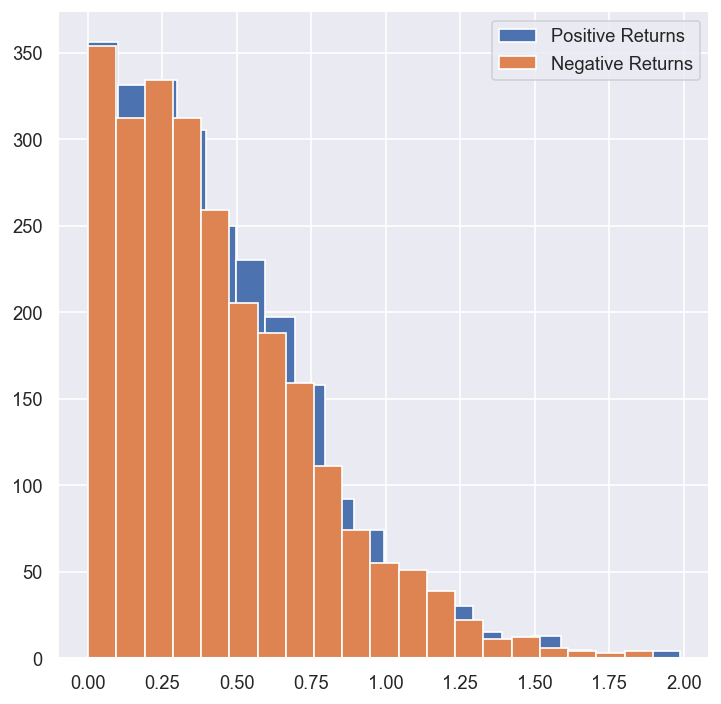

In [28]:
positive_returns = returns_df.loc[returns_df['Asset']>=0].Asset
negative_returns  = returns_df.loc[returns_df['Asset']<0].Asset
plt.hist(sorted(positive_returns.values), bins=20, label='Positive Returns')
plt.hist(sorted(abs(negative_returns.values)), bins=20, label='Negative Returns')
plt.legend(loc='best')

In [30]:
# Platykurtic (kurtosis < 3) short tails (fewer outliers) More stability because extreme price movements rarely occured in the past. 
print(scipy.stats.kurtosistest(returns_df.Asset))

# Positively skewed - outliers towards the right (positive returns) But very slightly alsmost 0
print(scipy.stats.skewtest(returns_df.Asset))

KurtosistestResult(statistic=1.7747948619459946, pvalue=0.0759317650368376)
SkewtestResult(statistic=0.09561321133134867, pvalue=0.9238277721505314)


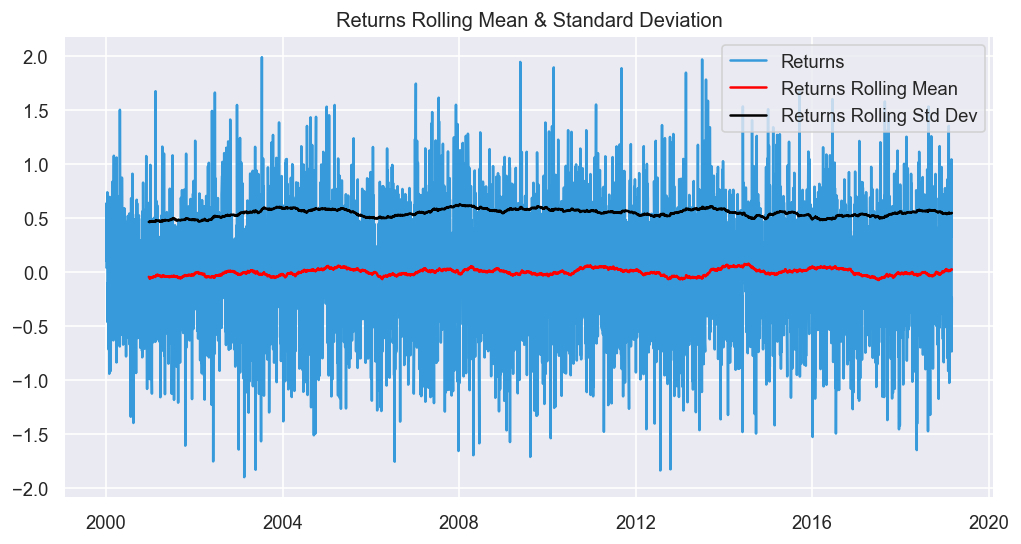

In [31]:
# Yearly values
rolling_avg_ret = returns_df.Asset.rolling(window=252).mean()
rolling_std_ret = returns_df.Asset.rolling(window=252).std()

# Plot rolling statistics
plt.figure(figsize=(10,5))
plt.plot(returns_df.Asset, color='#379BDB', label='Returns')
plt.plot(rolling_avg_ret,color='red', label='Returns Rolling Mean')
plt.plot(rolling_std_ret, color='black', label='Returns Rolling Std Dev')
plt.legend(loc='best')
plt.title('Returns Rolling Mean & Standard Deviation')
plt.show(block=False)


### Modelling

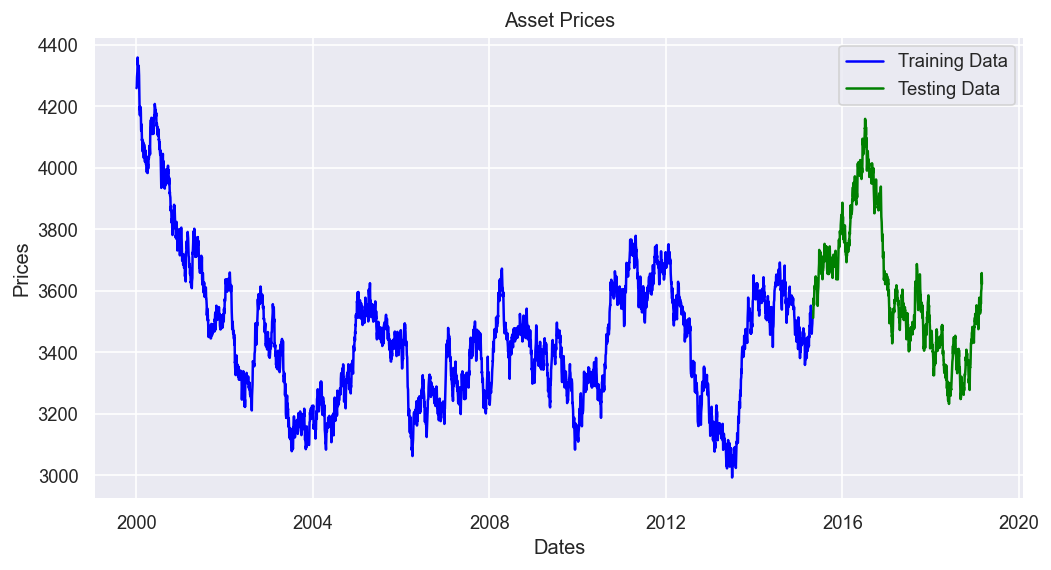

In [32]:
# Train - test split
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]
plt.figure(figsize=(10,5))
plt.title('Asset Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_train.Asset, 'blue', label='Training Data')
plt.plot(df_test.Asset, 'green', label='Testing Data')
plt.legend()

### ARMA on Assets

In [44]:
model_arima = pm.auto_arima(df_train.Asset)
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4000
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -17415.267
Date:                Wed, 10 May 2023   AIC                          34832.535
Time:                        07:20:22   BIC                          34838.829
Sample:                    01-03-2000   HQIC                         34834.766
                         - 05-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       354.9351      7.779     45.628      0.000     339.689     370.181
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.68   Prob(JB):                         0.57
Heteroskedasticity (H):               1.05   Skew:                             0.00
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

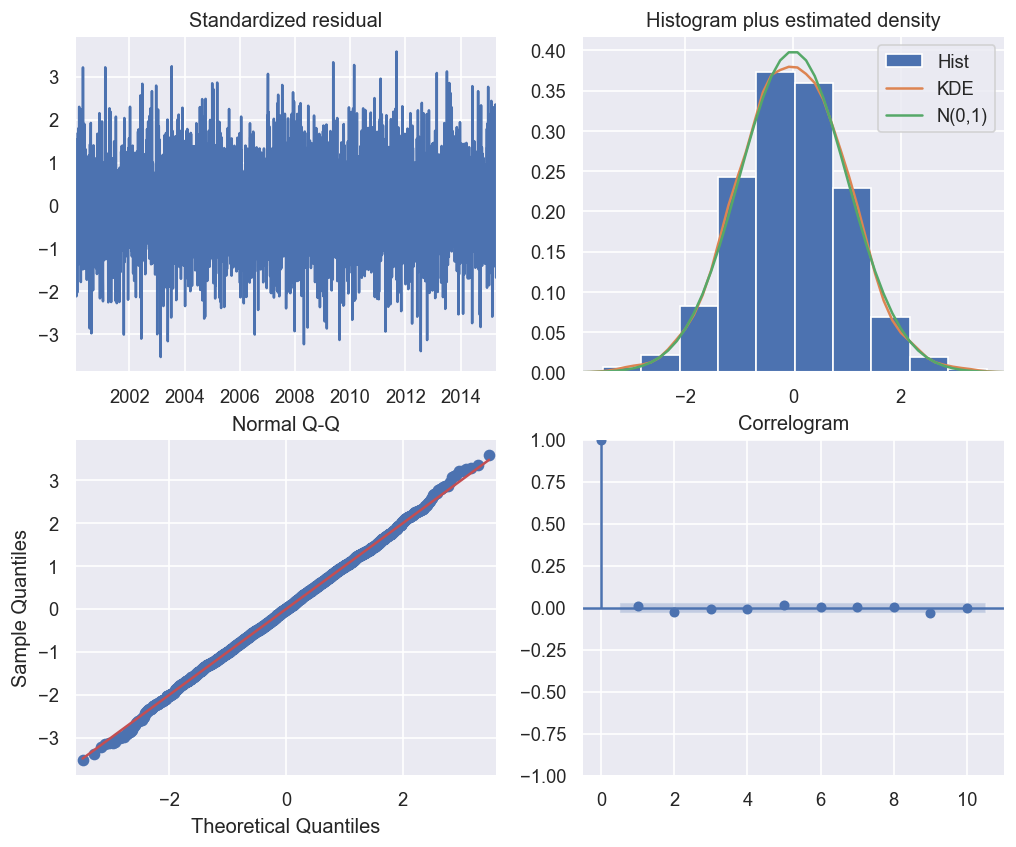

In [34]:
model_arima.plot_diagnostics(figsize=(10,8))
plt.show()

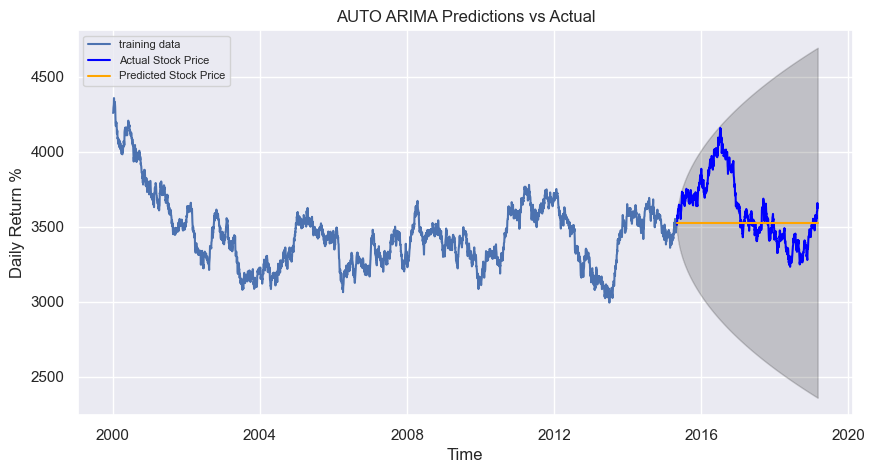

In [54]:
# Forecast
df_auto_pred, conf = model_arima.predict(n_periods=len(df_test), return_conf_int=True, alpha=0.05)  # 95% conf
df_auto_pred = pd.DataFrame(df_auto_pred.values, index = df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_train.Asset, label='training data')
plt.plot(df_test.Asset, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [46]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(df_test.Asset, df_auto_pred)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(df_test.Asset.values, df_auto_pred.values)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 53609.459
Symmetric mean absolute percentage error: 4.958


### ARIMAX

In [37]:
model_arimax = pm.auto_arima(y=df_train.Asset, X=df_train[['Signal1', 'Signal2', 'Signal3', 'Signal4', 'Signal5', 'Signal6', 'Signal7', 'Signal8']], m=5)
model_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4000
Model:             SARIMAX(1, 0, 2)x(2, 0, [], 5)   Log Likelihood              -14869.738
Date:                            Wed, 10 May 2023   AIC                          29769.476
Time:                                    07:17:13   BIC                          29863.886
Sample:                                01-03-2000   HQIC                         29802.942
                                     - 05-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.5469      9.667      0.781      0.435     -11.400      26.493
Signal1       -0.0106      0.011     -1.003      0.316      -0.031       0.010
Signal2        0.0061      0.010      0.598      0.550      -0.014       0.026
Signal3       -0.0025      0.011     -0.221      0.825      -0.024       0.019
Signal4        1.0106      0.012     87.058      0.000       0.988       1.033
Signal5       -0.0161      0.012     -1.374      0.170      -0.039       0.007
Signal6       -0.0138      0.011     -1.230      0.219      -0.036       0.008
Signal7       -0.0021      0.011     -0.197      0.843      -0.023       0.019
Signal8        0.0020      0.011      0.176      0.860      -0.020       0.024
ar.L1          0.9979      0.003    375.273      0.000       0.993       1.003
ma.L1         -0.0133      0.016     -0.847      0.397      -0.044       0.017
ma.L2         -0.0268      0.016     -1.686      0.092      -0.058       0.004
ar.S.L5        0.0297      0.016      1.853      0.064      -0.002       0.061
ar.S.L10      -0.0212      0.016     -1.330      0.184      -0.053       0.010
sigma2        99.0561      2.154     45.993      0.000      94.835     103.277
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.38
Prob(Q):                              0.99   Prob(JB):                         0.07
Heteroskedasticity (H):               1.00   Skew:                            -0.03
Prob(H) (two-sided):                  1.00   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

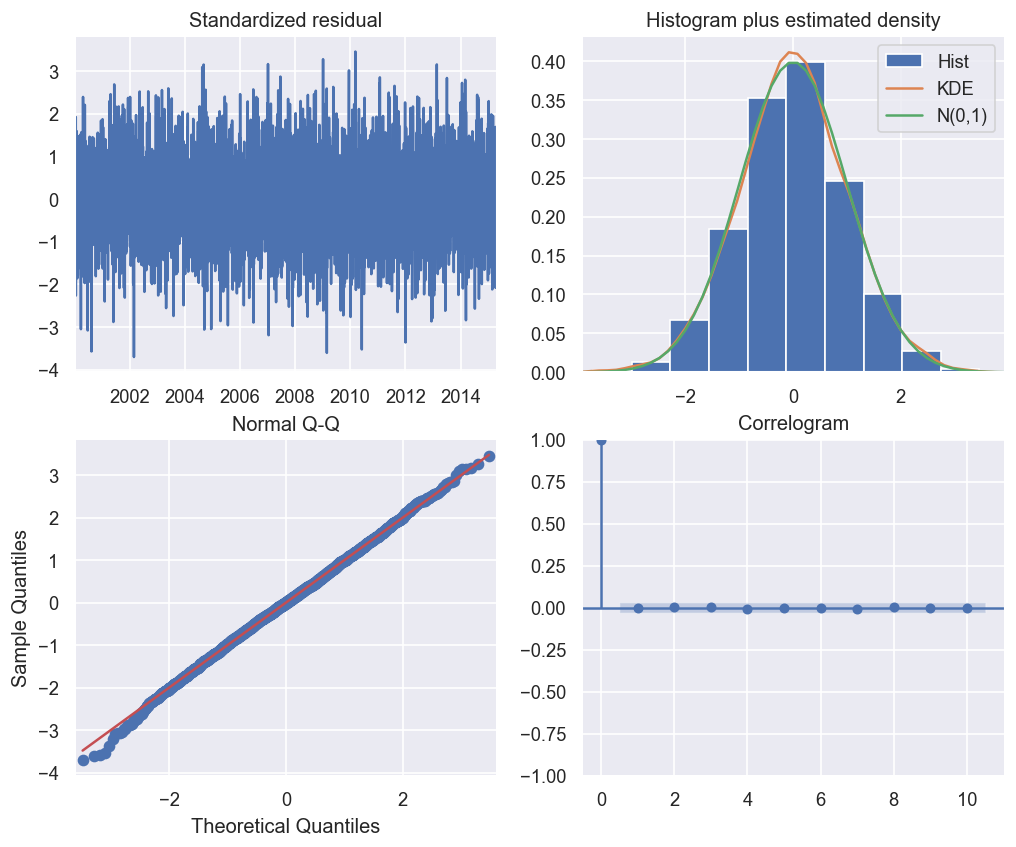

In [38]:
model_arimax.plot_diagnostics(figsize=(10,8))
plt.show()

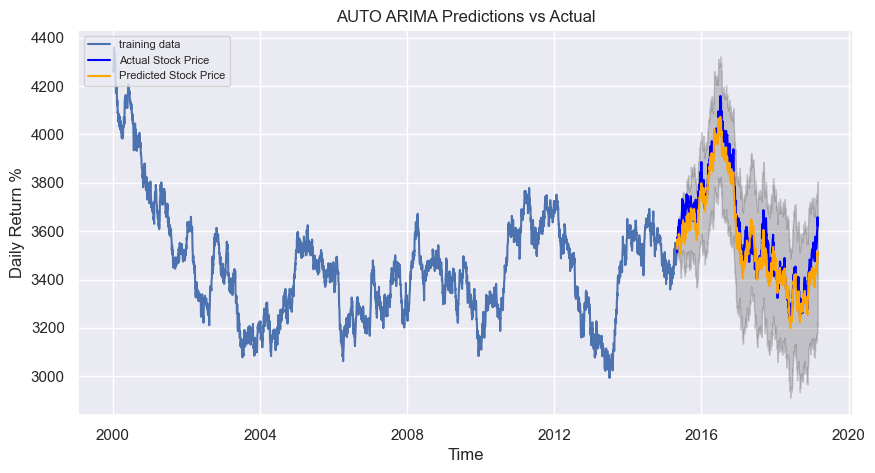

In [53]:
# Forecast
df_auto_pred, conf = model_arimax.predict(n_periods=len(df_test), X=df_test[['Signal1', 'Signal2', 'Signal3', 'Signal4', 'Signal5', 'Signal6', 'Signal7', 'Signal8']], return_conf_int=True, alpha=0.05)  # 95% conf
df_auto_pred = pd.DataFrame(df_auto_pred.values, index = df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_train.Asset, label='training data')
plt.plot(df_test.Asset, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [43]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(df_test.Asset, df_auto_pred)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(df_test.Asset.values, df_auto_pred.values)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 3529.467
Symmetric mean absolute percentage error: 6.643


### ARIMAX using Signal4 and Signal7

In [74]:
model_arimax = pm.auto_arima(y=df_train.Asset, X=df_train[['Signal4', 'Signal7']], m=5)
model_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4000
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood              -14862.594
Date:                           Wed, 10 May 2023   AIC                          29741.188
Time:                                   07:40:58   BIC                          29791.538
Sample:                               01-03-2000   HQIC                         29759.036
                                    - 05-01-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0035      0.005      0.745      0.456      -0.006       0.013
Signal4        1.0012      0.010    102.082      0.000       0.982       1.020
Signal7       -0.0112      0.010     -1.163      0.245      -0.030       0.008
ar.L1          0.9654      0.019     51.196      0.000       0.928       1.002
ma.L1         -0.9796      0.016    -62.472      0.000      -1.010      -0.949
ar.S.L5       -0.1269      0.375     -0.339      0.735      -0.861       0.608
ma.S.L5        0.1685      0.372      0.453      0.650      -0.560       0.897
sigma2        98.2629      2.125     46.246      0.000      94.098     102.427
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.91
Prob(Q):                              0.79   Prob(JB):                         0.09
Heteroskedasticity (H):               1.00   Skew:                            -0.04
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

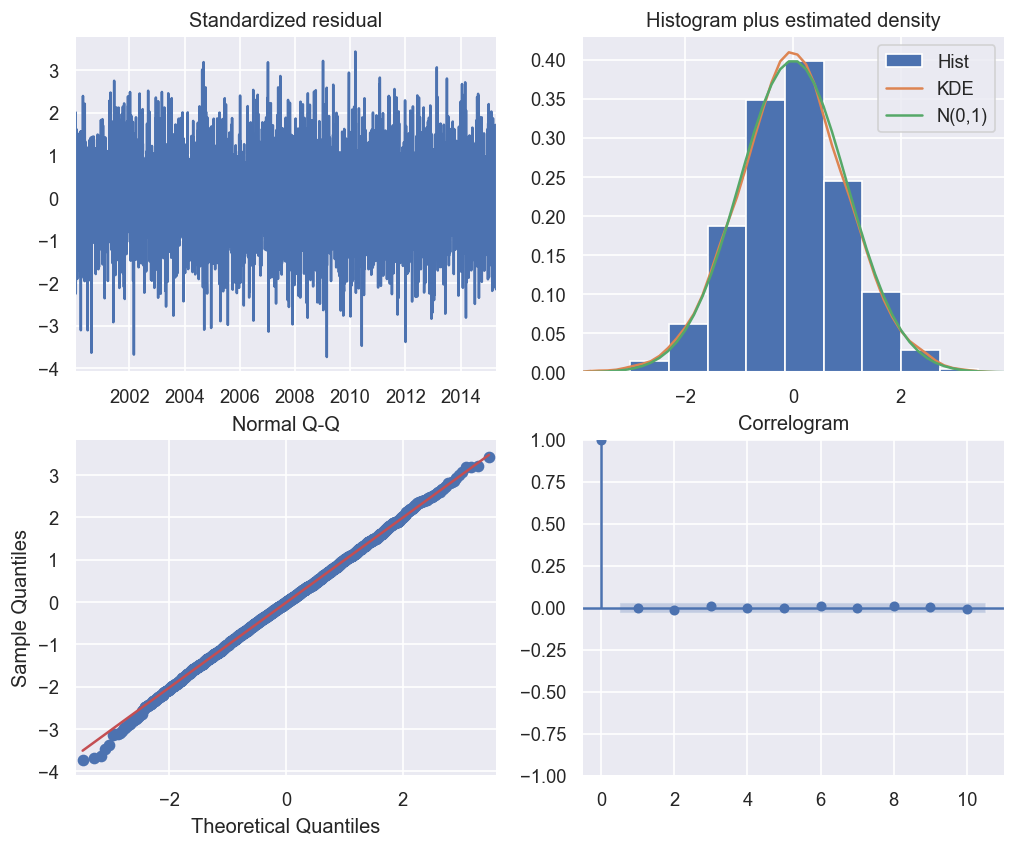

In [76]:
model_arimax.plot_diagnostics(figsize=(10,8))
plt.show()

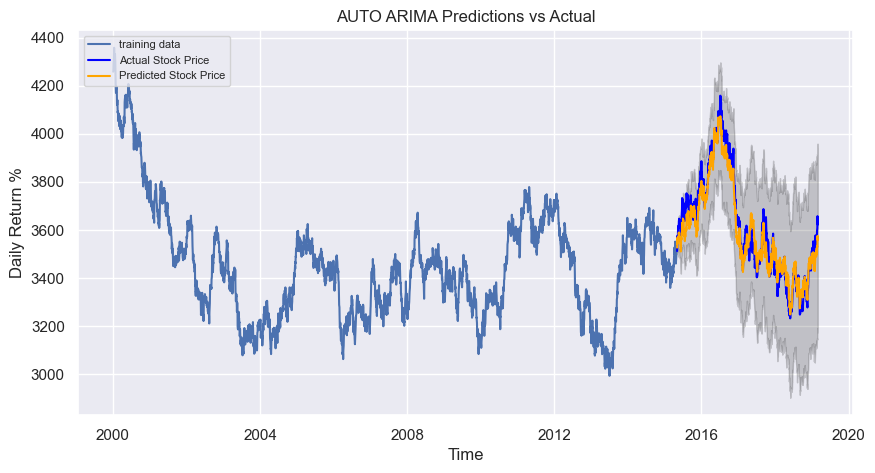

In [77]:
# Forecast
df_auto_pred, conf = model_arimax.predict(n_periods=len(df_test), X=df_test[['Signal4','Signal7']], return_conf_int=True, alpha=0.05)  # 95% conf
df_auto_pred = pd.DataFrame(df_auto_pred.values, index = df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_train.Asset, label='training data')
plt.plot(df_test.Asset, color = 'blue', label='Actual Stock Price')
plt.plot(df_auto_pred, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.20)
plt.title('AUTO ARIMA Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Daily Return %')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [78]:
error = mean_squared_error(df_test.Asset, df_auto_pred)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(df_test.Asset.values, df_auto_pred.values)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 2579.719
Symmetric mean absolute percentage error: 6.320


### LSTM

In [41]:
scaler = MinMaxScaler(feature_range=(0,1))
data = df.filter(['Asset'])
final_data = data.values

len_train_data = int(len(df)*0.8)
train_data = final_data[:len_train_data, :]
valid_data = final_data[len_train_data:, :]


scaled_data = scaler.fit_transform(final_data)

x_train_data, y_train_data = [], []

for i in range(60, len(train_data)):
    # take 60 previous observations as x
    x_train_data.append(scaled_data[i-60:i, 0])
    # take last observation in the 60 window as y
    y_train_data.append(scaled_data[i, 0])

x_train_data = np.array(x_train_data)
y_train_data = np.array(y_train_data)

In [47]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=50, input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=3,batch_size=1,verbose=2)

Epoch 1/3
3940/3940 - 89s - loss: 9.1789e-04 - 89s/epoch - 23ms/step
Epoch 2/3
3940/3940 - 81s - loss: 3.7983e-04 - 81s/epoch - 20ms/step
Epoch 3/3
3940/3940 - 74s - loss: 3.1853e-04 - 74s/epoch - 19ms/step


In [48]:
model_data = data[len(data)-len(valid_data)-60:].values 
model_data = model_data.reshape(-1,1)
model_data = scaler.transform(model_data)

X_test = []
for i in range(60, model_data.shape[0]):
    X_test.append(model_data[i-60:i,0]) 

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_test.shape

(1000, 60, 1)

In [49]:
predicted_stock_price = lstm_model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

32/32 [==============================] - 1s 9ms/step


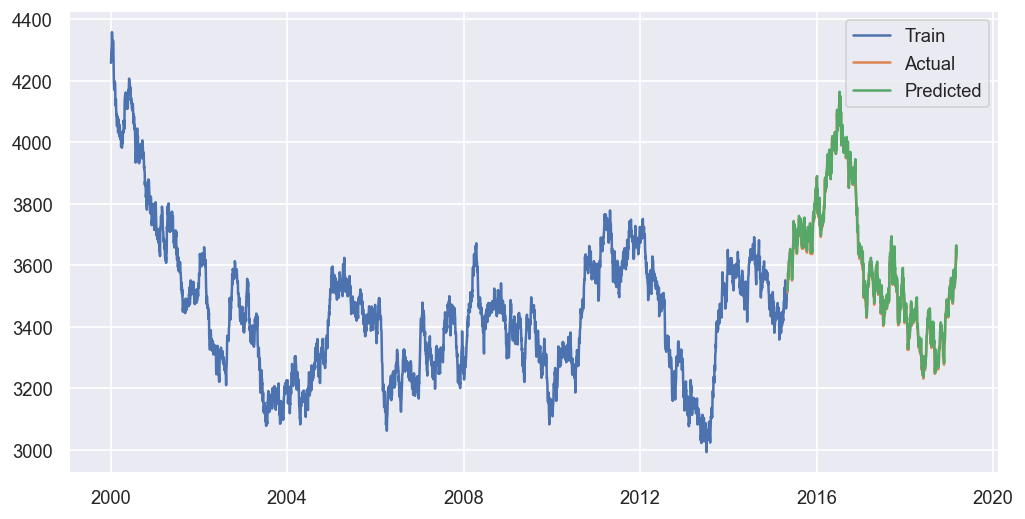

In [51]:
train_data = data[:len(train_data)]
valid_data = data[len(train_data):]
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(train_data['Asset'], label='Train')
plt.plot(valid_data['Asset'], label='Actual')
plt.plot(valid_data.index, predicted_stock_price, label = 'Predicted')
plt.legend()
plt.show()

In [92]:
error = mean_squared_error(valid_data, predicted_stock_price)
print('Testing Mean Squared Error %.3f' %error)

error2 = smape_kun(valid_data, predicted_stock_price)
print('Symmetric mean absolute percentage error: %.3f' %error2)

Testing Mean Squared Error 394.717
Symmetric mean absolute percentage error: 0.439


### Volatility

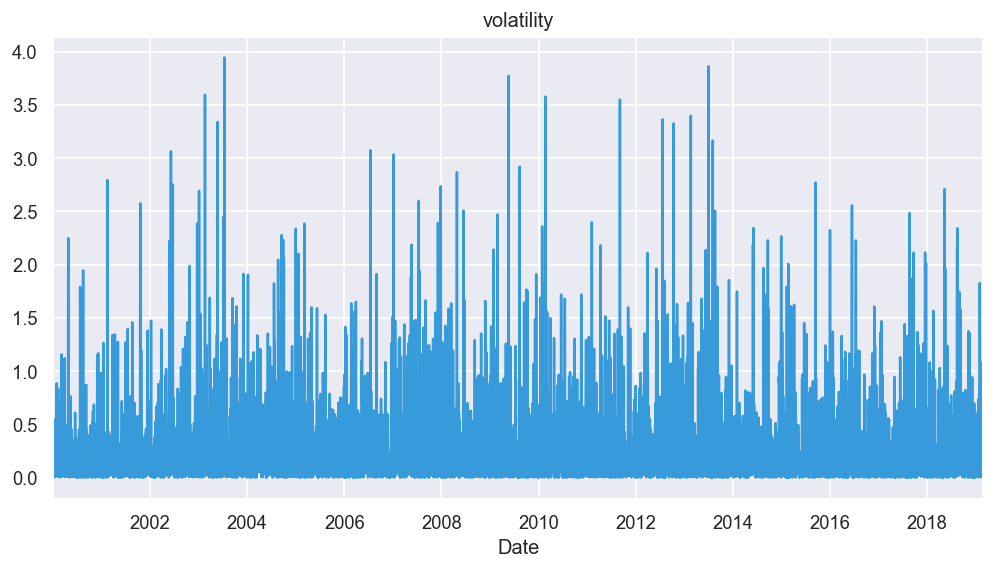

In [59]:
sq_returns = returns_df.Asset.mul(returns_df.Asset)
sq_returns.plot(figsize=(10,5), c='#379BDB')
plt.title('volatility')
plt.show()

In [60]:

volatility_df = pd.DataFrame()
volatility_df['Asset'] = returns_df.Asset.mul(returns_df.Asset)

for signal in signals:
    volatility_df[signal] = returns_df[signal].mul(returns_df[signal])

volatility_df.head()

,Asset,Signal1,Signal2,Signal3,Signal4,Signal5,Signal6,Signal7,Signal8
Date,,,,,,,,,
2000-01-04,0.001717,0.125372,14.890363,61.568324,2.691288,7.313135,0.617956,8.133351,42.606659
2000-01-05,0.002222,0.045398,9.019656,55.478280,1.375424,0.282581,4.044499,6.989931,35.649130
2000-01-06,0.405773,0.357396,18.350905,221.991792,43.899943,0.020580,2.292544,3.875777,71.336467
2000-01-07,0.010243,0.021374,0.656012,14.683227,0.034401,5.099178,0.537191,0.907971,77.955728
2000-01-10,0.180143,0.008813,6.625975,102.098999,0.037207,1.727117,0.877638,0.033259,52.059915


volatility_df.Asset.plot()
volatility_df.Signal4.plot()

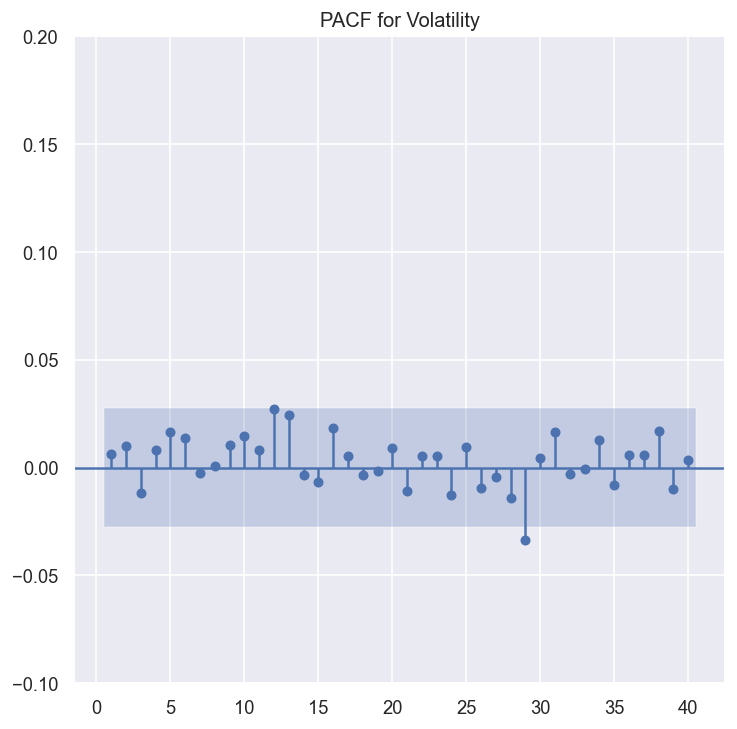

In [61]:
sgt.plot_pacf(sq_returns, lags=40, alpha = 0.05, zero=False, method=('ols'))
plt.title('PACF for Volatility')
plt.ylim(-0.1,0.2)
plt.show()

In [75]:
daily_volatility = returns_df.Asset.std()
monthly_volatility = np.sqrt(21)*daily_volatility
annual_volatility = np.sqrt(252)*daily_volatility

from tabulate import tabulate
print(tabulate([['Asset', daily_volatility, monthly_volatility, annual_volatility]], 
               headers=['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %']))

daily_volatility = returns_df.Signal4.std()
monthly_volatility = np.sqrt(21)*daily_volatility
annual_volatility = np.sqrt(252)*daily_volatility

from tabulate import tabulate
print(tabulate([['Signal4', daily_volatility, monthly_volatility, annual_volatility]], 
               headers=['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %']))

daily_volatility = returns_df.Signal7.std()
monthly_volatility = np.sqrt(21)*daily_volatility
annual_volatility = np.sqrt(252)*daily_volatility

from tabulate import tabulate
print(tabulate([['Signal7', daily_volatility, monthly_volatility, annual_volatility]], 
               headers=['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %']))

         Daily Volatility %    Monthly Volatility %    Annual Volatility %
-----  --------------------  ----------------------  ---------------------
Asset              0.545928                 2.50176                8.66634
           Daily Volatility %    Monthly Volatility %    Annual Volatility %
-------  --------------------  ----------------------  ---------------------
Signal4               14841.8                 68013.8                 235607
           Daily Volatility %    Monthly Volatility %    Annual Volatility %
-------  --------------------  ----------------------  ---------------------
Signal7               3.37868                 15.4831                53.6349


### Trading Strategy

In [79]:
buy_n_hold = []

for cur_value in df.Asset:
    buy_n_hold.append(cur_value - df.Asset[0])

890.6870724082269 940.4679475202506


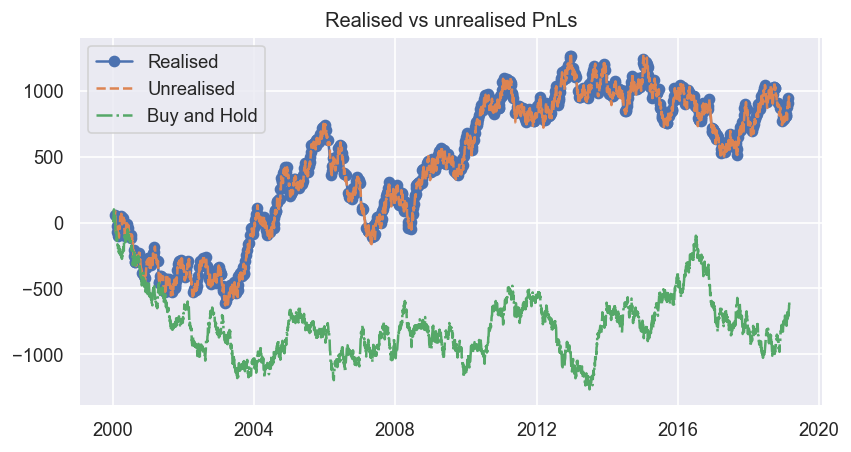

In [90]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0

# Positions
pos = []

# Prices
prices = []

# Realised PnL
rlsd = []

# Exit times
t = []

# MA windows
MA = [2,7]

for i in range(max(MA)+1, len(df)):
    # Moving Averages
    ma1 = np.mean(df.Asset[i-MA[0]:i])
    ma2 = np.mean(df.Asset[i-MA[1]:i])

    ma1_sig = np.mean(df.Signal4[i-MA[0]:i])
    ma2_sig = np.mean(df.Signal4[i-MA[1]:i])

    pos.append(inpos)
    prices.append(df.Asset[i])

    if ma1>ma2:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df.Asset[i]-entry)
                # record exit times
                t.append(df.index[i])
            # enter short position
            entry = df.Asset[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df.Asset[i])
                t.append(df.index[i])
            # enter long position
            entry = df.Asset[i]
            inpos = 1

unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

# Compare the realised and unrealised PnLs
plt.plot(t, np.cumsum(rlsd), '-o')
start = df.index.get_loc(t[0])
plt.plot(df.index[start:(start+len(unrlsd))],unrlsd[:-3], '--')
plt.plot(df.index, buy_n_hold, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])

In [82]:
rlsd_pos = [x for x in rlsd if x>0]
rlsd_neg = [x for x in rlsd if x<0]

profit_factor = -sum(rlsd_pos)/sum(rlsd_neg)
profit_factor

1.0700304130062652

-1550.3404226703183 -1541.7761689708218


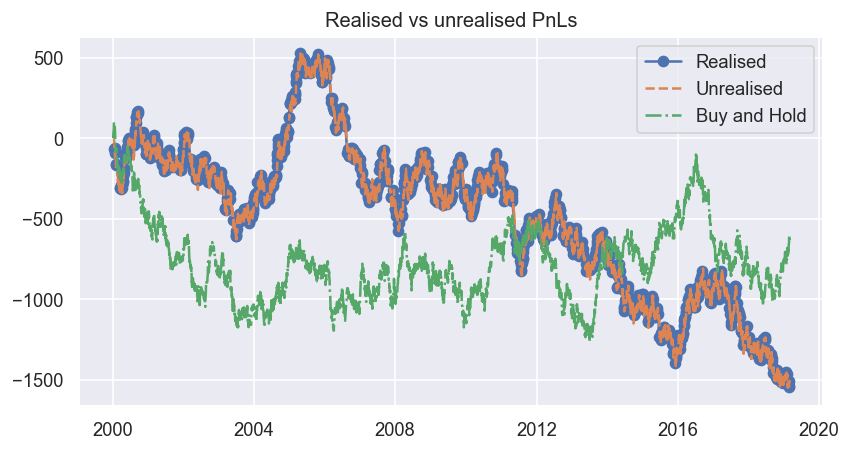

In [89]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0
# Positions
pos = []
# Prices
prices = []
# Realised PnL
rlsd= []
# Exit times
t = []

for i in range(3, len(df)):

    pos.append(inpos)
    prices.append(df.Asset[i])

    if returns_df.Asset[i-2]>0 and returns_df.Asset[i-1]>0 and returns_df.Asset[i-2]>0:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df.Asset[i]-entry)
                # record exit times
                t.append(df.index[i])
            # enter short position
            entry = df.Asset[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df.Asset[i])
                t.append(df.index[i])
            # enter long position
            entry = df.Asset[i]
            inpos = 1

unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

# Compare the realised and unrealised PnLs
plt.plot(t, np.cumsum(rlsd), '-o')
start = df.index.get_loc(t[0])
plt.plot(df.index[start:start+len(unrlsd)],unrlsd[:-4], '--')
plt.plot(df.index, buy_n_hold, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])

In [91]:
rlsd_pos = [x for x in rlsd if x>0]
rlsd_neg = [x for x in rlsd if x<0]

profit_factor = -sum(rlsd_pos)/sum(rlsd_neg)
profit_factor

1.0700304130062652

-1370.88109381401 -1362.3168401145135


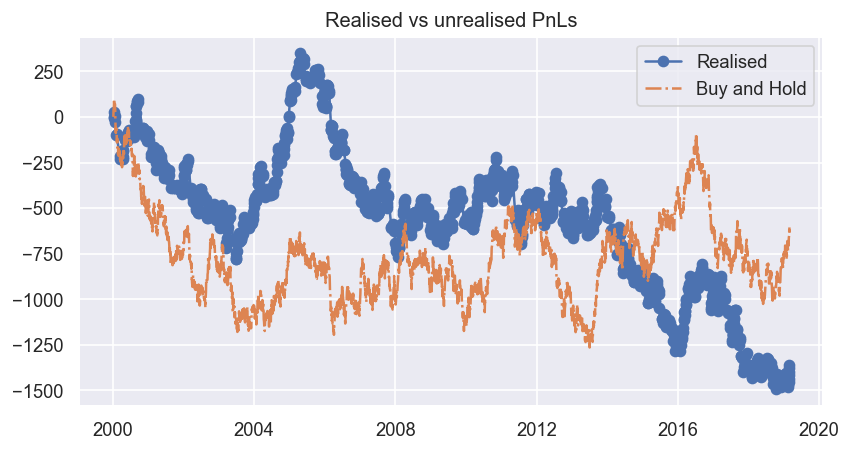

In [96]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0
# Positions
pos = []
# Prices
prices = []
# Realised PnL
rlsd= []
# Exit times
t = []

for i in range(3, len(df)):

    pos.append(inpos)
    prices.append(df.Asset[i])

    if (df.Asset[i]>df.Asset[i-1]) and (df.Asset[i-1]>df.Asset[i-2]) and (df.Signal4[i]-df.Signal4[i-1])>0:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df.Asset[i]-entry)
                # record exit times
                t.append(df.index[i])
            # enter short position
            entry = df.Asset[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df.Asset[i])
                t.append(df.index[i])
            # enter long position
            entry = df.Asset[i]
            inpos = 1

unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

#Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

# Compare the realised and unrealised PnLs
plt.plot(t, np.cumsum(rlsd), '-o')
start = df.index.get_loc(t[0])
# plt.plot(df.index[start:start+len(unrlsd)],unrlsd[:-4], '--')
plt.plot(df.index, buy_n_hold, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Buy and Hold'])

-760.1222673055568 -751.5580136060603


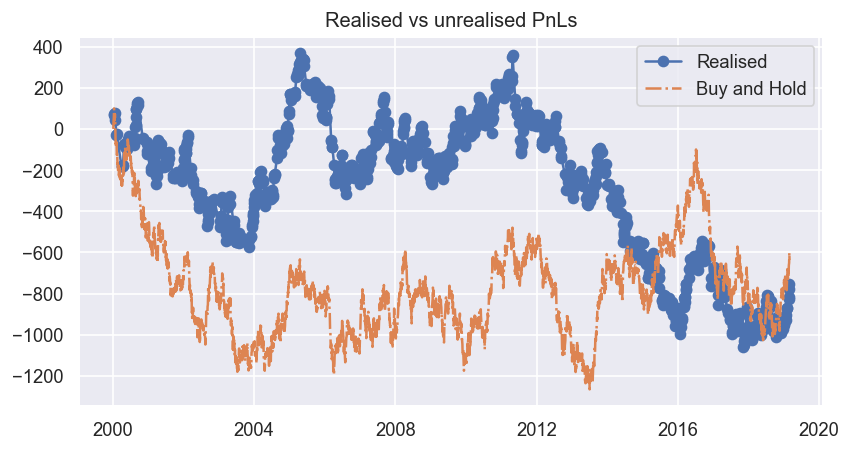

In [97]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0
# Positions
pos = []
# Prices
prices = []
# Realised PnL
rlsd= []
# Exit times
t = []

for i in range(3, len(df)):

    pos.append(inpos)
    prices.append(df.Asset[i])

    if (df.Asset[i]>df.Asset[i-1]) and (df.Asset[i-1]>df.Asset[i-2]) and (df.Signal4[i]>df.Signal4[i-1]) and (df.Signal4[i-1]>df.Signal4[i-2]):
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df.Asset[i]-entry)
                # record exit times
                t.append(df.index[i])
            # enter short position
            entry = df.Asset[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df.Asset[i])
                t.append(df.index[i])
            # enter long position
            entry = df.Asset[i]
            inpos = 1

unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

#Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

# Compare the realised and unrealised PnLs
plt.plot(t, np.cumsum(rlsd), '-o')
start = df.index.get_loc(t[0])
# plt.plot(df.index[start:start+len(unrlsd)],unrlsd[:-4], '--')
plt.plot(df.index, buy_n_hold, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Buy and Hold'])

928.6292678774885 993.302107980478


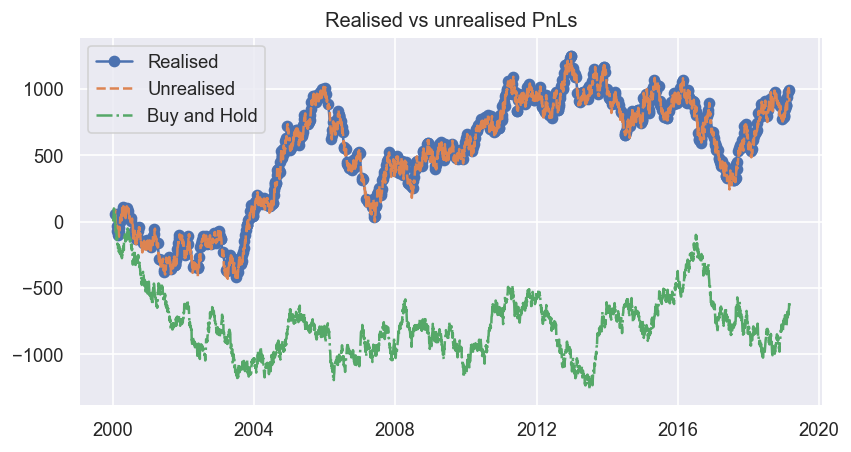

In [98]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0

# Positions
pos = []

# Prices
prices = []

# Realised PnL
rlsd = []

# Exit times
t = []

# MA windows
MA = [2,7]

for i in range(max(MA)+1, len(df)):
    # Moving Averages
    ma1 = np.mean(df.Asset[i-MA[0]:i])
    ma2 = np.mean(df.Asset[i-MA[1]:i])

    ma1_sig = np.mean(df.Signal4[i-MA[0]:i])
    ma2_sig = np.mean(df.Signal4[i-MA[1]:i])

    pos.append(inpos)
    prices.append(df.Asset[i])

    if ma1>ma2 and ma1_sig>ma2_sig:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df.Asset[i]-entry)
                # record exit times
                t.append(df.index[i])
            # enter short position
            entry = df.Asset[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df.Asset[i])
                t.append(df.index[i])
            # enter long position
            entry = df.Asset[i]
            inpos = 1

unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

# Compare the realised and unrealised PnLs
plt.plot(t, np.cumsum(rlsd), '-o')
start = df.index.get_loc(t[0])
plt.plot(df.index[start:(start+len(unrlsd))],unrlsd[:-3], '--')
plt.plot(df.index, buy_n_hold, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])

1869.6324134420715 1919.4132885540953


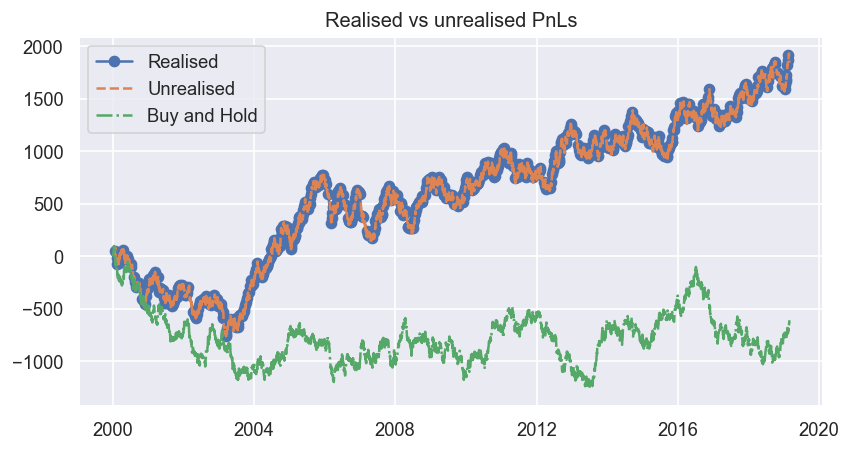

In [99]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0

# Positions
pos = []

# Prices
prices = []

# Realised PnL
rlsd = []

# Exit times
t = []

# MA windows
MA = [3, 7]

for i in range(max(MA)+1, len(df)):
    # Moving Averages
    ma1 = np.mean(df.Asset[i-MA[0]:i])
    ma2 = np.mean(df.Asset[i-MA[1]:i])

    ma1_sig = np.mean(df.Signal4[i-MA[0]:i])
    ma2_sig = np.mean(df.Signal4[i-MA[1]:i])

    pos.append(inpos)
    prices.append(df.Asset[i])

    if ma1>ma2:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df.Asset[i]-entry)
                # record exit times
                t.append(df.index[i])
            # enter short position
            entry = df.Asset[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df.Asset[i])
                t.append(df.index[i])
            # enter long position
            entry = df.Asset[i]
            inpos = 1

unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

# Compare the realised and unrealised PnLs
plt.plot(t, np.cumsum(rlsd), '-o')
start = df.index.get_loc(t[0])
plt.plot(df.index[start:(start+len(unrlsd))],unrlsd[:-3], '--')
plt.plot(df.index, buy_n_hold, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])

1827.5693052714955 1892.242145374485


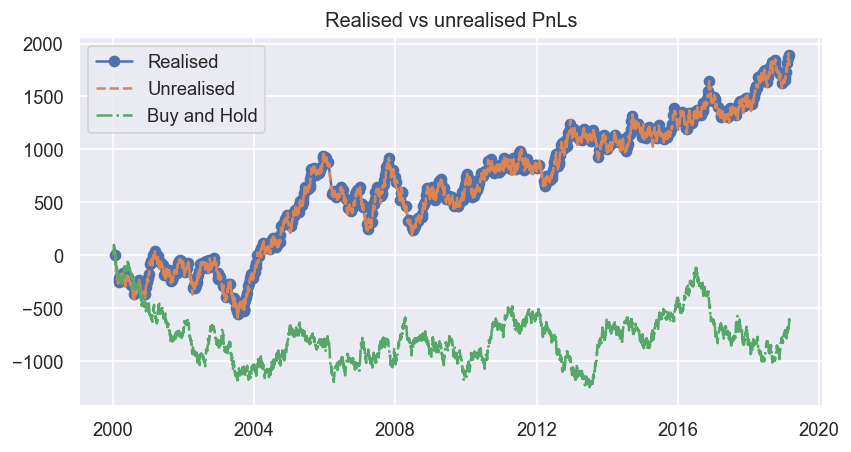

In [101]:
# Current position '0': not in position, '1': in long position, '-1': in short position
inpos = 0

# Positions
pos = []

# Prices
prices = []

# Realised PnL
rlsd = []

# Exit times
t = []

# MA windows
MA = [3,9]

for i in range(max(MA)+1, len(df)):
    # Moving Averages
    ma1 = np.mean(df.Asset[i-MA[0]:i])
    ma2 = np.mean(df.Asset[i-MA[1]:i])

    ma1_sig = np.mean(df.Signal4[i-MA[0]:i])
    ma2_sig = np.mean(df.Signal4[i-MA[1]:i])

    pos.append(inpos)
    prices.append(df.Asset[i])

    if ma1>ma2:
        if inpos != -1: # not in short position
            if inpos: # if long position -> exit
                rlsd.append(df.Asset[i]-entry)
                # record exit times
                t.append(df.index[i])
            # enter short position
            entry = df.Asset[i]
            inpos = -1
    else:
        if inpos !=1: # not in long position
            if inpos:
                rlsd.append(entry-df.Asset[i])
                t.append(df.index[i])
            # enter long position
            entry = df.Asset[i]
            inpos = 1

unrlsd = np.cumsum(np.multiply(np.diff(prices), pos[1:]))

# Compare the final realised and the final unrealised PnL
final_unrlsd = unrlsd[-1]
print(final_unrlsd, sum(rlsd))

# Compare the realised and unrealised PnLs
plt.plot(t, np.cumsum(rlsd), '-o')
start = df.index.get_loc(t[0])
plt.plot(df.index[start:(start+len(unrlsd))],unrlsd[:-2], '--')
plt.plot(df.index, buy_n_hold, '-.')
plt.title('Realised vs unrealised PnLs')
plt.legend(['Realised', 'Unrealised', 'Buy and Hold'])